In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [20]:
import tensorflow as tf
tf.compat.v1.enable_eager_execution()
tfe = tf.contrib.eager
import pyrednertensorflow as pyredner

import numpy as np

import pyrednertensorflow as pyrednertorch
import torch
import pdb
import scipy.ndimage as ndimage
import utils
import matplotlib.pyplot as plt
# Use GPU if available
pyredner.set_use_gpu(False)

In [3]:
# Load the scene from a Mitsuba scene file
scene = pyredner.load_mitsuba('scenes/teapot.xml')

# The last material is the teapot material, set it to the target
scene.materials[-1].diffuse_reflectance = \
    pyredner.Texture(tfe.Variable([0.3, 0.2, 0.2], ))
scene.materials[-1].specular_reflectance = \
    pyredner.Texture(tfe.Variable([0.6, 0.6, 0.6], ))
scene.materials[-1].roughness = \
    pyredner.Texture(tfe.Variable([0.05], ))
scene_args = pyredner.serialize_scene(
    scene = scene,
    num_samples = 1024,
    max_bounces = 2)


scenetorch = pyrednertorch.load_mitsuba('scenes/teapot.xml')

# The last material is the teapot material, set it to the target
scenetorch.materials[-1].diffuse_reflectance = \
    pyrednertorch.Texture(torch.tensor([0.3, 0.2, 0.2], device = pyrednertorch.get_device()))
scenetorch.materials[-1].specular_reflectance = \
    pyrednertorch.Texture(torch.tensor([0.6, 0.6, 0.6], device = pyrednertorch.get_device()))
scenetorch.materials[-1].roughness = \
    pyrednertorch.Texture(torch.tensor([0.05], device = pyrednertorch.get_device()))
scene_argstorch = pyrednertorch.RenderFunction.serialize_scene(\
    scene = scenetorch,
    num_samples = 1024,
    max_bounces = 2)

In [4]:
assert utils.is_same_scene(scene, scenetorch)

In [5]:
img = pyredner.render(*pyredner.get_render_args(0, scene_args))
pyredner.imwrite(img, 'results/test_teapot_reflectance/target.exr')
pyredner.imwrite(img, 'results/test_teapot_reflectance/target.png')
target = pyredner.imread('results/test_teapot_reflectance/target.exr')


rendertorch = pyrednertorch.RenderFunction.apply
imgtorch = rendertorch(0, *scene_argstorch)
targettorch = pyrednertorch.imread('results/test_teapot_reflectance/target.exr')

W0709 06:33:08.822949 139781786339072 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Forward pass, time: 13.16066 s
Scene construction, time: 0.10695 s
Forward pass, time: 13.00491 s


In [6]:
assert utils.is_same_tensor(img, imgtorch)
assert utils.is_same_tensor(target, targettorch)
assert utils.is_same_scene(scene, scenetorch)

In [7]:
cam = scene.camera
camtorch = scenetorch.camera

In [8]:
assert utils.is_same_camera(cam, camtorch)

In [9]:
cam_position = cam.position
cam_translation = tfe.Variable([-0.2, 0.2, -0.2], trainable=True)
scene.camera = pyredner.Camera(position     = cam_position + cam_translation,
                               look_at      = cam.look_at + cam_translation,
                               up           = cam.up,
                               fov          = cam.fov,
                               clip_near    = cam.clip_near,
                               resolution   = cam.resolution,
                               fisheye      = False)


cam_positiontorch = camtorch.position
cam_translationtorch = torch.tensor([-0.2, 0.2, -0.2], requires_grad = True)
scenetorch.camera = pyrednertorch.Camera(
                               position     = cam_positiontorch + cam_translationtorch,
                               look_at      = camtorch.look_at + cam_translationtorch,
                               up           = camtorch.up,
                               fov          = camtorch.fov,
                               clip_near    = camtorch.clip_near,
                               resolution   = camtorch.resolution,
                               fisheye      = False)

In [10]:
assert utils.is_same_camera(scene.camera, scenetorch.camera)

Detach
Detach


In [11]:
diffuse_reflectance = tfe.Variable([0.3, 0.3, 0.3], trainable=True)
specular_reflectance = tfe.Variable([0.5, 0.5, 0.5], trainable=True)
roughness = tfe.Variable([0.2], trainable=True)
scene.materials[-1].diffuse_reflectance = pyredner.Texture(diffuse_reflectance)
scene.materials[-1].specular_reflectance = pyredner.Texture(specular_reflectance)
scene.materials[-1].roughness = pyredner.Texture(roughness)

diffuse_reflectancetorch = torch.tensor([0.3, 0.3, 0.3],
    device = pyrednertorch.get_device(), requires_grad = True)
specular_reflectancetorch = torch.tensor([0.5, 0.5, 0.5],
    device = pyrednertorch.get_device(), requires_grad = True)
roughnesstorch = torch.tensor([0.2],
    device = pyrednertorch.get_device(), requires_grad = True)
scenetorch.materials[-1].diffuse_reflectance = pyrednertorch.Texture(diffuse_reflectancetorch)
scenetorch.materials[-1].specular_reflectance = pyrednertorch.Texture(specular_reflectancetorch)
scenetorch.materials[-1].roughness = pyrednertorch.Texture(roughnesstorch)

In [12]:
assert utils.is_same_scene(scene, scenetorch)

Detach
Detach
Detach
Detach
Detach
Detach
Detach
Detach


In [13]:
scene_args = pyredner.serialize_scene(
    scene = scene,
    num_samples = 1024,
    max_bounces = 2)
img = pyredner.render(*pyredner.get_render_args(1, scene_args))
diff = tf.abs(target - img)

scene_argstorch = pyrednertorch.RenderFunction.serialize_scene(\
    scene = scenetorch,
    num_samples = 1024,
    max_bounces = 2)
# Render the initial guess
imgtorch = rendertorch(1, *scene_argstorch)
difftorch = torch.abs(targettorch - imgtorch)

Forward pass, time: 13.73428 s
Scene construction, time: 0.10590 s
Forward pass, time: 14.20094 s


In [14]:
assert utils.is_same_tensor(img, imgtorch)

Detach


In [15]:
lr = 1e-2
optimizer = tf.train.AdamOptimizer(lr)
optimizertorch = torch.optim.Adam([diffuse_reflectancetorch,
                              specular_reflectancetorch,
                              roughnesstorch,
                              cam_translationtorch], lr=lr)

In [16]:
t = 0
num_iteration = 400

In [30]:
print('iteration:', t)

assert utils.is_same_tensor(diffuse_reflectance, diffuse_reflectancetorch)
assert utils.is_same_tensor(specular_reflectance, specular_reflectancetorch)
assert utils.is_same_tensor(roughness, roughnesstorch)
assert utils.is_same_tensor(cam_translation, cam_translationtorch)


optimizertorch.zero_grad()

scenetorch.camera = pyrednertorch.Camera(
    position   = cam_positiontorch + cam_translationtorch,
    look_at    = camtorch.look_at + cam_translationtorch,
    up         = camtorch.up,
    fov        = camtorch.fov,
    clip_near  = camtorch.clip_near,
    resolution = camtorch.resolution,
    fisheye    = False)
scene_argstorch = pyrednertorch.RenderFunction.serialize_scene(\
    scene = scenetorch,
    num_samples = 4,
    max_bounces = 2)
imgtorch = rendertorch(t+1, *scene_argstorch)
pyrednertorch.imwrite(imgtorch.cpu(), 'results/test_teapot_reflectance/torchiter_{}.png'.format(t))

difftorch = imgtorch - targettorch
diractorch = np.zeros([7,7], dtype = np.float32)
diractorch[3,3] = 1.0
diractorch = torch.from_numpy(diractorch)
ftorch = np.zeros([3, 3, 7, 7], dtype = np.float32)
gftorch = ndimage.filters.gaussian_filter(diractorch, 1.0)
ftorch[0, 0, :, :] = gftorch
ftorch[1, 1, :, :] = gftorch
ftorch[2, 2, :, :] = gftorch
ftorch = torch.from_numpy(ftorch)
mtorch = torch.nn.AvgPool2d(2)
r = 256
diff_0torch = (imgtorch - targettorch).view(1, r, r, 3).permute(0, 3, 2, 1)

diff_1torch = mtorch(torch.nn.functional.conv2d(diff_0torch, ftorch, padding=3))
diff_2torch = mtorch(torch.nn.functional.conv2d(diff_1torch, ftorch, padding=3))
diff_3torch = mtorch(torch.nn.functional.conv2d(diff_2torch, ftorch, padding=3))
diff_4torch = mtorch(torch.nn.functional.conv2d(diff_3torch, ftorch, padding=3))
diff_5torch = mtorch(torch.nn.functional.conv2d(diff_4torch, ftorch, padding=3))
losstorch = diff_0torch.pow(2).sum() / (r*r) + \
       diff_1torch.pow(2).sum() / ((r/2)*(r/2)) + \
       diff_2torch.pow(2).sum() / ((r/4)*(r/4)) + \
       diff_3torch.pow(2).sum() / ((r/8)*(r/8)) + \
       diff_4torch.pow(2).sum() / ((r/16)*(r/16)) + \
       diff_5torch.pow(2).sum() / ((r/32)*(r/32))

with tf.GradientTape() as tape:
    # Forward pass: render the image
    # need to rerun Camera constructor for autodiff 
    scene.camera = pyredner.Camera(position     = cam_position + cam_translation,
                                look_at      = cam.look_at + cam_translation,
                                up           = cam.up,
                                fov          = cam.fov,

                                clip_near    = cam.clip_near,
                                resolution   = cam.resolution,
                                fisheye      = False)
    scene_args = pyredner.serialize_scene(
        scene = scene,
        num_samples = 4,
        max_bounces = 2)
    img = pyredner.render(*pyredner.get_render_args(t+1, scene_args))
    pyredner.imwrite(img, 'results/test_teapot_reflectance/iter_{}.png'.format(t))

    # NOTE: Loss in reflectance is bit special!
    diff = img - target
    # dirac = np.zeros([7,7], dtype = np.float32)
    dirac = tf.constant(
        [
            [0, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 1.0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0]
        ],
        dtype=tf.float32
    )
    # dirac[3,3] = 1.0
    # dirac = tf.convert_to_tensor(dirac, dtype=tf.float32)
    # f = np.zeros([3, 3, 7, 7], dtype = np.float32)
    gf = ndimage.filters.gaussian_filter(dirac, 1.0)
    # f[0, 0, :, :] = gf
    # f[1, 1, :, :] = gf
    # f[2, 2, :, :] = gf
    # f = tf.convert_to_tensor(f, dtype=tf.float32)

    f = tf.concat([
            tf.reshape(
                tf.concat(
                    [tf.reshape(gf, [1, 7,7]),
                    tf.constant(np.zeros([1,7,7], dtype=np.float32), dtype=tf.float32),
                    tf.constant(np.zeros([1,7,7], dtype=np.float32), dtype=tf.float32)],
                    axis=0
                ), 
                [1,3,7,7]
            ),
            tf.reshape(
                tf.concat([
                    tf.constant(np.zeros([1,7,7], dtype=np.float32), dtype=tf.float32),
                    tf.reshape(gf, [1, 7,7]),
                    tf.constant(np.zeros([1,7,7], dtype=np.float32), dtype=tf.float32)],
                    axis=0
                ), 
                [1,3,7,7]
            ),
            tf.reshape(
                tf.concat([
                    tf.constant(np.zeros([1,7,7], dtype=np.float32), dtype=tf.float32),
                    tf.constant(np.zeros([1,7,7], dtype=np.float32), dtype=tf.float32),
                    tf.reshape(gf, [1, 7,7])],
                    axis=0
                ), 
                [1,3,7,7
            ])
            ],
            axis=0
        )
    # padding = [[0,0],[3,3],[3,3],[0,0]]
    # tf.nn.conv2d(diff_0, ff, padding=padding, data_format='NHWC')
    def conv(x, filter):
        '''
            m = torch.nn.AvgPool2d(2)
            m(torch.nn.functional.conv2d(diff_0, f, padding=3))

        Torch uses NCHW
        TF uses NHWC
        '''
        padding = [
            [0,0], # Minibatch
            [3,3],
            [3,3],
            [0,0]
        ]
        # y = tf.nn.conv2d(x, filter, padding=padding, data_format='NCHW')
        y = tf.nn.conv2d(x, filter, padding=padding, data_format='NHWC')
        y = tf.nn.avg_pool2d(y, ksize=2, strides=2, padding='VALID', data_format='NHWC')
        return y

    r = 256
    # NOTE: `perm` must change according to the `data_format`
    diff_0 = tf.transpose(tf.reshape(img - target, (1, r, r, 3)), perm=[0,2,1,3])  
    f = tf.transpose(f, perm=[2,3,0,1])
    # pdb.set_trace()
    diff_1 = conv(diff_0, f)
    diff_2 = conv(diff_1, f)
    diff_3 = conv(diff_2, f)
    diff_4 = conv(diff_3, f)
    diff_5 = conv(diff_4, f)

    loss = tf.reduce_sum(tf.pow(diff_0, 2)) / (r*r) + \
        tf.reduce_sum(tf.pow(diff_1, 2)) / ((r/2)*(r/2)) + \
        tf.reduce_sum(tf.pow(diff_2, 2)) / ((r/4)*(r/4)) + \
        tf.reduce_sum(tf.pow(diff_3, 2)) / ((r/8)*(r/8)) + \
        tf.reduce_sum(tf.pow(diff_4, 2)) / ((r/16)*(r/16)) + \
        tf.reduce_sum(tf.pow(diff_5, 2)) / ((r/32)*(r/32))


assert utils.is_same_image(img, imgtorch)
assert utils.is_same_tensor(diff, difftorch)
assert utils.is_same_tensor(dirac, diractorch)
assert np.allclose(gf, gftorch)

assert utils.is_same_tensor(tf.transpose(diff_0, perm=[0,3,1,2]), diff_0torch)
assert utils.is_same_tensor(tf.transpose(diff_2, perm=[0,3,1,2]), diff_2torch)
assert utils.is_same_tensor(tf.transpose(diff_3, perm=[0,3,1,2]), diff_3torch)
assert utils.is_same_tensor(tf.transpose(diff_4, perm=[0,3,1,2]), diff_4torch)
assert utils.is_same_tensor(tf.transpose(diff_5, perm=[0,3,1,2]), diff_5torch)


# assert utils.is_same_tensor(f, ftorch.permute(2,3,0,1))

grads = tape.gradient(
        loss, 
        [diffuse_reflectance, specular_reflectance, roughness, cam_translation]
    )

losstorch.backward()

print('diffuse_reflectance.grad:', grads[0].numpy())
print('specular_reflectance.grad:', grads[1].numpy())
print('roughness.grad:', grads[2].numpy())
print('cam_translation.grad:', grads[3].numpy())

print('diffuse_reflectance.grad:', diffuse_reflectancetorch.grad)
print('specular_reflectance.grad:', specular_reflectancetorch.grad)
print('roughness.grad:', roughnesstorch.grad)
print('cam_translation.grad:', cam_translationtorch.grad)

assert utils.is_same_tensor(grads[0], diffuse_reflectancetorch.grad)
assert utils.is_same_tensor(grads[1], specular_reflectancetorch.grad)
assert utils.is_same_tensor(grads[2], roughnesstorch.grad)
assert utils.is_same_tensor(grads[3], cam_translationtorch.grad)

grads[2] = tf.clip_by_norm(grads[2], 10)
grads[3] = tf.clip_by_norm(grads[3], 10)

# HACK: gradient clipping to deal with outlier gradients
torch.nn.utils.clip_grad_norm_(roughnesstorch, 10)
torch.nn.utils.clip_grad_norm_(cam_translationtorch, 10)

print(">>> AFTER CLIPPING")
print('diffuse_reflectance.grad:', grads[0].numpy())
print('specular_reflectance.grad:', grads[1].numpy())
print('roughness.grad:', grads[2].numpy())
print('cam_translation.grad:', grads[3].numpy())

print('diffuse_reflectance.grad:', diffuse_reflectancetorch.grad)
print('specular_reflectance.grad:', specular_reflectancetorch.grad)
print('roughness.grad:', roughnesstorch.grad)
print('cam_translation.grad:', cam_translationtorch.grad)

assert utils.is_same_tensor(grads[0], diffuse_reflectancetorch.grad)
assert utils.is_same_tensor(grads[1], specular_reflectancetorch.grad)
assert utils.is_same_tensor(grads[2], roughnesstorch.grad)
assert utils.is_same_tensor(grads[3], cam_translationtorch.grad)


optimizer.apply_gradients(
    zip(
        grads, 
        [diffuse_reflectance, specular_reflectance, roughness, cam_translation])
)

optimizertorch.step()

assert utils.is_same_tensor(diffuse_reflectance, diffuse_reflectancetorch)
assert utils.is_same_tensor(specular_reflectance, specular_reflectancetorch)
assert utils.is_same_tensor(roughness, roughnesstorch)
assert utils.is_same_tensor(cam_translation, cam_translationtorch)

plt.figure()
plt.imshow(img)

plt.figure()
plt.imshow(imgtorch.detach())

t += 1

iteration: 3
Detach
Detach
Detach
Detach
Scene construction, time: 0.10660 s


W0709 06:38:10.156275 139781786339072 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Forward pass, time: 0.11692 s


W0709 06:38:10.426195 139781786339072 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Forward pass, time: 0.09516 s
Detach
Detach
Detach
R - channel is different
G - channel is different
B - channel is different


AssertionError: 

In [31]:
loss

<tf.Tensor: id=4682, shape=(), dtype=float32, numpy=0.0399385>

In [26]:
grads[3], cam_translationtorch.grad

(<tf.Tensor: id=4171, shape=(3,), dtype=float32, numpy=array([-0.02414647,  0.03983361, -0.02229929], dtype=float32)>,
 tensor([-0.0246,  0.0392, -0.0221]))

In [28]:
grads[3], cam_translationtorch.grad

(<tf.Tensor: id=4217, shape=(3,), dtype=float32, numpy=array([-0.02414647,  0.03983361, -0.02229929], dtype=float32)>,
 tensor([-0.0246,  0.0392, -0.0221]))

W0709 06:35:14.598647 139781786339072 image.py:693] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


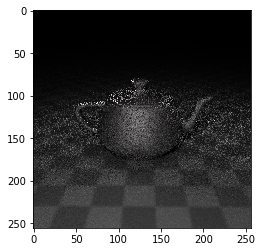

In [23]:
plt.figure()
plt.imshow(img)

W0709 06:35:29.906772 139781786339072 image.py:693] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


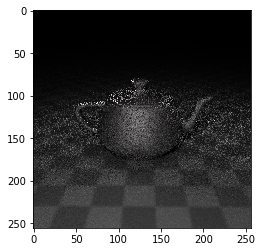

In [25]:
plt.figure()
plt.imshow(imgtorch.detach())

In [19]:
grads[0], diffuse_reflectancetorch.grad

(<tf.Tensor: id=3123, shape=(3,), dtype=float32, numpy=array([0.03597753, 0.04608551, 0.04608551], dtype=float32)>,
 tensor([-1.0145e-02, -3.7140e-05, -3.7140e-05]))

In [ ]:
lr = 1e-2
optimizer = tf.train.AdamOptimizer(lr)
optimizertorch = torch.optim.Adam([diffuse_reflectance,
                              specular_reflectance,
                              roughness,
                              cam_translation], lr=lr)
